In [1]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow-hub
from datetime import datetime

W0518 22:51:28.211261 139881778222976 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
!pip install bert-tensorflow
import bert # pip install bert-tensorflow
from bert import run_classifier
from bert import optimization
from bert import tokenization

     |████████████████████████████████| 71kB 3.4MB/s 


In [3]:
# Only run this if your doing this on colab, you will have to upload the data to drive too
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def create_model(is_predicting, #Bool to say if we're predicting (or training) as the output we'd like from the model would move
                 input_ids, # We know that our train_input_fn will pass the inputs as tensor of mini_batch_size, they
                 #actually come as one dictionary but in the next cell we see that in model_fn we split them out
                 input_mask, 
                 segment_ids, 
                 labels,
                 num_labels): # Num labels just lets us define the size of our softmax level for classification
    """Creates a classification model."""

    # Get the BERT model again from tf hub, this time setting trainable as true as we will fine tune it
    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    
    # We have our input tensors, the ones for the pre-trained bert are just being grouped here for convinience
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    
    # We already saw earlier in the notebook, 'tokens' is the standard endpoint that gives the reference tensors coming out of BERT
    # Unlike 'tokenization_info' here we need to pass the inputs to get the outputs.
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # From the tf hub docs for BERT we know we can use "pooled_output" for classification tasks on an entire sentence.
    # Or use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own classification layer
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
        
        print(output_layer.shape)
        print([BATCH_SIZE * MAX_SEQ_LENGTH, hidden_size])

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
              return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)
      
      
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, 
                     learning_rate, 
                     num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    
    tf.reset_default_graph()

    def model_fn(features, 
                 labels, 
                 mode, 
                 params): 
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Here we run our model and return our loss function and friends
            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            # Here we define a training op, this one comes from BERT we will open this up in a second and have a look whats going on
            # but logically it makes sense what its doing, actually running the training
            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics and call them. This is a little subtle, the types of metrics we can use are limited to
            # tf's tf.metrics library which is definetly not exaustive (no multiclass f1 score...), as such what we can actually 
            # do is largely ignore this and calculate the metrics in python with the returned probabilites on the test set
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                return {"eval_accuracy": accuracy}

            eval_metrics = metric_fn(label_ids, predicted_labels)

            # Next we create a different end point for model_fn depending on what we're doing (training, predicting, etc)
            # All of these are instances of tf.estimator.EstimatorSpec which we will unpack below

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
               is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn
  
  
def get_prediction(in_sentences):
  """
  Helper function to run the pipeline for a list of examples to classify
  """
  labels = ['Negative', 'Neutral', 'Positive']

  # As in 2.1. get input exaple objects in a list for every prediction example
  input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 'Neutral') for x in in_sentences]

  # As in 2.3 convert to the classes that BERT will ultimately understand (still in python format here)
  input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  # As in 3.2 we need an input function for the estimator, this just converts the data above to tensors to serve to the estimator
  predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, 
                                                          seq_length=MAX_SEQ_LENGTH, 
                                                          is_training=False, 
                                                          drop_remainder=False)

  # Run the model this time on .predict which as defined by our model_fn will return probabilities and labels
  predictions = estimator.predict(predict_input_fn)

  # Returns a list of tuples (sentence, probs, label) for each example we passed
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

    
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


"""Get the vocab file and casing info from the Hub module."""
with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        
tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                            do_lower_case=do_lower_case)

print(tokenizer.tokenize("This here's an example of using the BERT tokenizer"))

vocab_df = pd.DataFrame(np.array([list(tokenizer.vocab.keys()), list(tokenizer.vocab.values())]).T, columns=["Vocab", "ID"])
print(vocab_df.sample(n=10))

DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
label_list = ['Negative', 'Neutral', 'Positive']

Instructions for updating:
Colocations handled automatically by placer.


W0518 22:51:59.310721 139881778222976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0518 22:52:01.489235 139881778222976 saver.py:1483] Saver not created because there are no variables in the graph to restore


['this', 'here', "'", 's', 'an', 'example', 'of', 'using', 'the', 'bert', 'token', '##izer']
              Vocab     ID
7910             uh   7910
3820      agreement   3820
25120   meaningless  25120
27073        ##gaon  27073
12154         gains  12154
16747  biographical  16747
16023      dividing  16023
25272       nouveau  25272
24178      ##ellant  24178
24240         queue  24240


# 1.0 Data

In [0]:
tasks = ['amazon_movies', 'amazon_health', 'amazon_books', 'semeval_task_a', 'semeval_task_ce']
sub_tasks = ['fair_balanced_100', 'fair_balanced_300', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

MAX_SEQ_LENGTH = 128

# Model configs
SAVE_CHECKPOINTS_STEPS = 10000
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1


INFO:tensorflow:Writing example 0 of 300


I0518 22:52:22.955687 139881778222976 run_classifier.py:774] Writing example 0 of 300


INFO:tensorflow:*** Example ***


I0518 22:52:22.966124 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:22.968175 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i like stanley ku ##brick he was a magnificent director , he knew ho ##s to create mystery in the stories he directed , sometimes scary and sometimes very slow . he was a versatile director , he could direct any kind of movies , that shows how good he was . but , i can ' t qualify this movie , it ' s like one of those strange dreams you have and looks so real , and you don ' t know if it is real or not . tom cruise gets into an & quo ##t ; underworld & quo ##t ; of people with strange ho ##bbies , like und ##ress ##ing women in a sort of church ; he gets in [SEP]


I0518 22:52:22.970018 139881778222976 run_classifier.py:464] tokens: [CLS] i like stanley ku ##brick he was a magnificent director , he knew ho ##s to create mystery in the stories he directed , sometimes scary and sometimes very slow . he was a versatile director , he could direct any kind of movies , that shows how good he was . but , i can ' t qualify this movie , it ' s like one of those strange dreams you have and looks so real , and you don ' t know if it is real or not . tom cruise gets into an & quo ##t ; underworld & quo ##t ; of people with strange ho ##bbies , like und ##ress ##ing women in a sort of church ; he gets in [SEP]


INFO:tensorflow:input_ids: 101 1045 2066 6156 13970 25646 2002 2001 1037 12047 2472 1010 2002 2354 7570 2015 2000 3443 6547 1999 1996 3441 2002 2856 1010 2823 12459 1998 2823 2200 4030 1012 2002 2001 1037 22979 2472 1010 2002 2071 3622 2151 2785 1997 5691 1010 2008 3065 2129 2204 2002 2001 1012 2021 1010 1045 2064 1005 1056 7515 2023 3185 1010 2009 1005 1055 2066 2028 1997 2216 4326 5544 2017 2031 1998 3504 2061 2613 1010 1998 2017 2123 1005 1056 2113 2065 2009 2003 2613 2030 2025 1012 3419 8592 4152 2046 2019 1004 22035 2102 1025 13607 1004 22035 2102 1025 1997 2111 2007 4326 7570 27982 1010 2066 6151 8303 2075 2308 1999 1037 4066 1997 2277 1025 2002 4152 1999 102


I0518 22:52:22.972891 139881778222976 run_classifier.py:465] input_ids: 101 1045 2066 6156 13970 25646 2002 2001 1037 12047 2472 1010 2002 2354 7570 2015 2000 3443 6547 1999 1996 3441 2002 2856 1010 2823 12459 1998 2823 2200 4030 1012 2002 2001 1037 22979 2472 1010 2002 2071 3622 2151 2785 1997 5691 1010 2008 3065 2129 2204 2002 2001 1012 2021 1010 1045 2064 1005 1056 7515 2023 3185 1010 2009 1005 1055 2066 2028 1997 2216 4326 5544 2017 2031 1998 3504 2061 2613 1010 1998 2017 2123 1005 1056 2113 2065 2009 2003 2613 2030 2025 1012 3419 8592 4152 2046 2019 1004 22035 2102 1025 13607 1004 22035 2102 1025 1997 2111 2007 4326 7570 27982 1010 2066 6151 8303 2075 2308 1999 1037 4066 1997 2277 1025 2002 4152 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:22.975549 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:22.978498 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:52:22.982078 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:52:22.992170 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:22.994030 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this film is a prime example of why it rarely , if ever , goes good for a director to write a film , which is of course why writers tend to . . . to say that this film is boring is an under ##sta ##tem ##ent , in fact the preview ##s are far more interesting and all ##uring than watching this garbage , and i would also state that watching paint dry would be about as fun while being less painful . < br / > < br / > the fake scottish accent , when seems to come and go , even transform into a british one briefly , then an american one briefly and back into fake scottish . . . [SEP]


I0518 22:52:22.996119 139881778222976 run_classifier.py:464] tokens: [CLS] this film is a prime example of why it rarely , if ever , goes good for a director to write a film , which is of course why writers tend to . . . to say that this film is boring is an under ##sta ##tem ##ent , in fact the preview ##s are far more interesting and all ##uring than watching this garbage , and i would also state that watching paint dry would be about as fun while being less painful . < br / > < br / > the fake scottish accent , when seems to come and go , even transform into a british one briefly , then an american one briefly and back into fake scottish . . . [SEP]


INFO:tensorflow:input_ids: 101 2023 2143 2003 1037 3539 2742 1997 2339 2009 6524 1010 2065 2412 1010 3632 2204 2005 1037 2472 2000 4339 1037 2143 1010 2029 2003 1997 2607 2339 4898 7166 2000 1012 1012 1012 2000 2360 2008 2023 2143 2003 11771 2003 2019 2104 9153 18532 4765 1010 1999 2755 1996 19236 2015 2024 2521 2062 5875 1998 2035 12228 2084 3666 2023 13044 1010 1998 1045 2052 2036 2110 2008 3666 6773 4318 2052 2022 2055 2004 4569 2096 2108 2625 9145 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 8275 4104 9669 1010 2043 3849 2000 2272 1998 2175 1010 2130 10938 2046 1037 2329 2028 4780 1010 2059 2019 2137 2028 4780 1998 2067 2046 8275 4104 1012 1012 1012 102


I0518 22:52:22.997945 139881778222976 run_classifier.py:465] input_ids: 101 2023 2143 2003 1037 3539 2742 1997 2339 2009 6524 1010 2065 2412 1010 3632 2204 2005 1037 2472 2000 4339 1037 2143 1010 2029 2003 1997 2607 2339 4898 7166 2000 1012 1012 1012 2000 2360 2008 2023 2143 2003 11771 2003 2019 2104 9153 18532 4765 1010 1999 2755 1996 19236 2015 2024 2521 2062 5875 1998 2035 12228 2084 3666 2023 13044 1010 1998 1045 2052 2036 2110 2008 3666 6773 4318 2052 2022 2055 2004 4569 2096 2108 2625 9145 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 8275 4104 9669 1010 2043 3849 2000 2272 1998 2175 1010 2130 10938 2046 1037 2329 2028 4780 1010 2059 2019 2137 2028 4780 1998 2067 2046 8275 4104 1012 1012 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:23.000229 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.002125 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0518 22:52:23.003522 139881778222976 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0518 22:52:23.030050 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:23.031543 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the day the earth stood still is a classic that never should have been re - made . this re - make bears very little resemblance to the original 1951 robert wise film . going one step further , even if this film had no advertised links to the original it still would have been bad . the only red ##eem ##ing feature in buying this dvd is that the original version of the film was included on disk 2 . granted that the special effects in the 2008 movie sur ##pass anything that could be imagined in 1951 , the original film has two things the new version will never have : a good story and credible acting . as such it is easy to [SEP]


I0518 22:52:23.033360 139881778222976 run_classifier.py:464] tokens: [CLS] the day the earth stood still is a classic that never should have been re - made . this re - make bears very little resemblance to the original 1951 robert wise film . going one step further , even if this film had no advertised links to the original it still would have been bad . the only red ##eem ##ing feature in buying this dvd is that the original version of the film was included on disk 2 . granted that the special effects in the 2008 movie sur ##pass anything that could be imagined in 1951 , the original film has two things the new version will never have : a good story and credible acting . as such it is easy to [SEP]


INFO:tensorflow:input_ids: 101 1996 2154 1996 3011 2768 2145 2003 1037 4438 2008 2196 2323 2031 2042 2128 1011 2081 1012 2023 2128 1011 2191 6468 2200 2210 14062 2000 1996 2434 4131 2728 7968 2143 1012 2183 2028 3357 2582 1010 2130 2065 2023 2143 2018 2053 17099 6971 2000 1996 2434 2009 2145 2052 2031 2042 2919 1012 1996 2069 2417 21564 2075 3444 1999 9343 2023 4966 2003 2008 1996 2434 2544 1997 1996 2143 2001 2443 2006 9785 1016 1012 4379 2008 1996 2569 3896 1999 1996 2263 3185 7505 15194 2505 2008 2071 2022 8078 1999 4131 1010 1996 2434 2143 2038 2048 2477 1996 2047 2544 2097 2196 2031 1024 1037 2204 2466 1998 23411 3772 1012 2004 2107 2009 2003 3733 2000 102


I0518 22:52:23.035089 139881778222976 run_classifier.py:465] input_ids: 101 1996 2154 1996 3011 2768 2145 2003 1037 4438 2008 2196 2323 2031 2042 2128 1011 2081 1012 2023 2128 1011 2191 6468 2200 2210 14062 2000 1996 2434 4131 2728 7968 2143 1012 2183 2028 3357 2582 1010 2130 2065 2023 2143 2018 2053 17099 6971 2000 1996 2434 2009 2145 2052 2031 2042 2919 1012 1996 2069 2417 21564 2075 3444 1999 9343 2023 4966 2003 2008 1996 2434 2544 1997 1996 2143 2001 2443 2006 9785 1016 1012 4379 2008 1996 2569 3896 1999 1996 2263 3185 7505 15194 2505 2008 2071 2022 8078 1999 4131 1010 1996 2434 2143 2038 2048 2477 1996 2047 2544 2097 2196 2031 1024 1037 2204 2466 1998 23411 3772 1012 2004 2107 2009 2003 3733 2000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:23.036743 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.038458 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0518 22:52:23.039914 139881778222976 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0518 22:52:23.043860 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:23.045367 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is probably one of my favorite britney concert specials she did . i really enjoyed this dvd . i would recommend it to anybody ! i only gave it 4 out of 5 stars because it lacked bonus material , actually it had none at all . i think it would have been a little better with behind the scenes or something like that featured on the menu . over all i enjoyed the concert . i was glad to add this to my collection . this is definitely for any britney collector / fan ! [SEP]


I0518 22:52:23.046923 139881778222976 run_classifier.py:464] tokens: [CLS] this is probably one of my favorite britney concert specials she did . i really enjoyed this dvd . i would recommend it to anybody ! i only gave it 4 out of 5 stars because it lacked bonus material , actually it had none at all . i think it would have been a little better with behind the scenes or something like that featured on the menu . over all i enjoyed the concert . i was glad to add this to my collection . this is definitely for any britney collector / fan ! [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2763 2028 1997 2026 5440 29168 4164 19247 2016 2106 1012 1045 2428 5632 2023 4966 1012 1045 2052 16755 2009 2000 10334 999 1045 2069 2435 2009 1018 2041 1997 1019 3340 2138 2009 10858 6781 3430 1010 2941 2009 2018 3904 2012 2035 1012 1045 2228 2009 2052 2031 2042 1037 2210 2488 2007 2369 1996 5019 2030 2242 2066 2008 2956 2006 1996 12183 1012 2058 2035 1045 5632 1996 4164 1012 1045 2001 5580 2000 5587 2023 2000 2026 3074 1012 2023 2003 5791 2005 2151 29168 10018 1013 5470 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.048384 139881778222976 run_classifier.py:465] input_ids: 101 2023 2003 2763 2028 1997 2026 5440 29168 4164 19247 2016 2106 1012 1045 2428 5632 2023 4966 1012 1045 2052 16755 2009 2000 10334 999 1045 2069 2435 2009 1018 2041 1997 1019 3340 2138 2009 10858 6781 3430 1010 2941 2009 2018 3904 2012 2035 1012 1045 2228 2009 2052 2031 2042 1037 2210 2488 2007 2369 1996 5019 2030 2242 2066 2008 2956 2006 1996 12183 1012 2058 2035 1045 5632 1996 4164 1012 1045 2001 5580 2000 5587 2023 2000 2026 3074 1012 2023 2003 5791 2005 2151 29168 10018 1013 5470 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.050397 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.051894 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0518 22:52:23.053233 139881778222976 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0518 22:52:23.055280 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:23.056737 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is one of the best small screen comedies i ' ve seen in ages . typical british humour with great acting . [SEP]


I0518 22:52:23.058205 139881778222976 run_classifier.py:464] tokens: [CLS] this is one of the best small screen comedies i ' ve seen in ages . typical british humour with great acting . [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2028 1997 1996 2190 2235 3898 22092 1045 1005 2310 2464 1999 5535 1012 5171 2329 17211 2007 2307 3772 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.059496 139881778222976 run_classifier.py:465] input_ids: 101 2023 2003 2028 1997 1996 2190 2235 3898 22092 1045 1005 2310 2464 1999 5535 1012 5171 2329 17211 2007 2307 3772 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.061021 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:23.062447 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0518 22:52:23.063941 139881778222976 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:Writing example 0 of 15000


I0518 22:52:24.276966 139881778222976 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0518 22:52:24.289555 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:24.292412 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is a must - see action thriller that has an excellent story that dare ##s to challenge the way we think about our legal system , but be ##ware it is not intended for the sq ##ui ##mis ##h at heart considering its violent content ( def ##inate ##ly not one for the kids since rape , murder , and mu ##tila ##tion are all part of the package ) . i would agree with the other reviews , which in es ##cence collectively agrees that this movie starts out strong in the beginning , but . . . it was almost as if they ran out of time towards the end and had to start chop ##ping footage to get it all worked into [SEP]


I0518 22:52:24.295001 139881778222976 run_classifier.py:464] tokens: [CLS] this is a must - see action thriller that has an excellent story that dare ##s to challenge the way we think about our legal system , but be ##ware it is not intended for the sq ##ui ##mis ##h at heart considering its violent content ( def ##inate ##ly not one for the kids since rape , murder , and mu ##tila ##tion are all part of the package ) . i would agree with the other reviews , which in es ##cence collectively agrees that this movie starts out strong in the beginning , but . . . it was almost as if they ran out of time towards the end and had to start chop ##ping footage to get it all worked into [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 1037 2442 1011 2156 2895 10874 2008 2038 2019 6581 2466 2008 8108 2015 2000 4119 1996 2126 2057 2228 2055 2256 3423 2291 1010 2021 2022 8059 2009 2003 2025 3832 2005 1996 5490 10179 15630 2232 2012 2540 6195 2049 6355 4180 1006 13366 14776 2135 2025 2028 2005 1996 4268 2144 9040 1010 4028 1010 1998 14163 26065 3508 2024 2035 2112 1997 1996 7427 1007 1012 1045 2052 5993 2007 1996 2060 4391 1010 2029 1999 9686 29320 13643 10217 2008 2023 3185 4627 2041 2844 1999 1996 2927 1010 2021 1012 1012 1012 2009 2001 2471 2004 2065 2027 2743 2041 1997 2051 2875 1996 2203 1998 2018 2000 2707 24494 4691 8333 2000 2131 2009 2035 2499 2046 102


I0518 22:52:24.298120 139881778222976 run_classifier.py:465] input_ids: 101 2023 2003 1037 2442 1011 2156 2895 10874 2008 2038 2019 6581 2466 2008 8108 2015 2000 4119 1996 2126 2057 2228 2055 2256 3423 2291 1010 2021 2022 8059 2009 2003 2025 3832 2005 1996 5490 10179 15630 2232 2012 2540 6195 2049 6355 4180 1006 13366 14776 2135 2025 2028 2005 1996 4268 2144 9040 1010 4028 1010 1998 14163 26065 3508 2024 2035 2112 1997 1996 7427 1007 1012 1045 2052 5993 2007 1996 2060 4391 1010 2029 1999 9686 29320 13643 10217 2008 2023 3185 4627 2041 2844 1999 1996 2927 1010 2021 1012 1012 1012 2009 2001 2471 2004 2065 2027 2743 2041 1997 2051 2875 1996 2203 1998 2018 2000 2707 24494 4691 8333 2000 2131 2009 2035 2499 2046 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:24.301362 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.306000 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0518 22:52:24.309288 139881778222976 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:*** Example ***


I0518 22:52:24.313594 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:24.315421 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i bought this 6 years ago because the remake of the texas chains ##aw massacre was coming out . when i watched it , i thought it sucked and had stupid situations and leather ##face looked like a girl . stick with the original , the remake , and the prequel . not this ! i would not recommend the texas chains ##aw massacre : the next generation ! ! ! [SEP]


I0518 22:52:24.317540 139881778222976 run_classifier.py:464] tokens: [CLS] i bought this 6 years ago because the remake of the texas chains ##aw massacre was coming out . when i watched it , i thought it sucked and had stupid situations and leather ##face looked like a girl . stick with the original , the remake , and the prequel . not this ! i would not recommend the texas chains ##aw massacre : the next generation ! ! ! [SEP]


INFO:tensorflow:input_ids: 101 1045 4149 2023 1020 2086 3283 2138 1996 12661 1997 1996 3146 8859 10376 9288 2001 2746 2041 1012 2043 1045 3427 2009 1010 1045 2245 2009 8631 1998 2018 5236 8146 1998 5898 12172 2246 2066 1037 2611 1012 6293 2007 1996 2434 1010 1996 12661 1010 1998 1996 28280 1012 2025 2023 999 1045 2052 2025 16755 1996 3146 8859 10376 9288 1024 1996 2279 4245 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.319727 139881778222976 run_classifier.py:465] input_ids: 101 1045 4149 2023 1020 2086 3283 2138 1996 12661 1997 1996 3146 8859 10376 9288 2001 2746 2041 1012 2043 1045 3427 2009 1010 1045 2245 2009 8631 1998 2018 5236 8146 1998 5898 12172 2246 2066 1037 2611 1012 6293 2007 1996 2434 1010 1996 12661 1010 1998 1996 28280 1012 2025 2023 999 1045 2052 2025 16755 1996 3146 8859 10376 9288 1024 1996 2279 4245 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.322253 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.326135 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0518 22:52:24.329329 139881778222976 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0518 22:52:24.335301 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:24.336917 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] growing pain ' s tracey gold gets to bear her fangs as a psychotic young woman who kills people and takes their identities . her latest : she kills a young college student and assumes her place at a ri ##tz ##y little college where she sets her sights on her room ##ie ' s hu ##nk ##y and rich dad . < br / > < br / > gold is quite good in the role , and she gets good support from perry king as the dad and shawn ##ee smith ( saw movies ) as her good ##y two shoes roommate . < br / > < br / > it ' s all been done before but gold is so des ##pic [SEP]


I0518 22:52:24.339704 139881778222976 run_classifier.py:464] tokens: [CLS] growing pain ' s tracey gold gets to bear her fangs as a psychotic young woman who kills people and takes their identities . her latest : she kills a young college student and assumes her place at a ri ##tz ##y little college where she sets her sights on her room ##ie ' s hu ##nk ##y and rich dad . < br / > < br / > gold is quite good in the role , and she gets good support from perry king as the dad and shawn ##ee smith ( saw movies ) as her good ##y two shoes roommate . < br / > < br / > it ' s all been done before but gold is so des ##pic [SEP]


INFO:tensorflow:input_ids: 101 3652 3255 1005 1055 25984 2751 4152 2000 4562 2014 11738 2004 1037 27756 2402 2450 2040 8563 2111 1998 3138 2037 15702 1012 2014 6745 1024 2016 8563 1037 2402 2267 3076 1998 15980 2014 2173 2012 1037 15544 5753 2100 2210 2267 2073 2016 4520 2014 15925 2006 2014 2282 2666 1005 1055 15876 8950 2100 1998 4138 3611 1012 1026 7987 1013 1028 1026 7987 1013 1028 2751 2003 3243 2204 1999 1996 2535 1010 1998 2016 4152 2204 2490 2013 6890 2332 2004 1996 3611 1998 13218 4402 3044 1006 2387 5691 1007 2004 2014 2204 2100 2048 6007 18328 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2035 2042 2589 2077 2021 2751 2003 2061 4078 24330 102


I0518 22:52:24.353610 139881778222976 run_classifier.py:465] input_ids: 101 3652 3255 1005 1055 25984 2751 4152 2000 4562 2014 11738 2004 1037 27756 2402 2450 2040 8563 2111 1998 3138 2037 15702 1012 2014 6745 1024 2016 8563 1037 2402 2267 3076 1998 15980 2014 2173 2012 1037 15544 5753 2100 2210 2267 2073 2016 4520 2014 15925 2006 2014 2282 2666 1005 1055 15876 8950 2100 1998 4138 3611 1012 1026 7987 1013 1028 1026 7987 1013 1028 2751 2003 3243 2204 1999 1996 2535 1010 1998 2016 4152 2204 2490 2013 6890 2332 2004 1996 3611 1998 13218 4402 3044 1006 2387 5691 1007 2004 2014 2204 2100 2048 6007 18328 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2035 2042 2589 2077 2021 2751 2003 2061 4078 24330 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:24.362439 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.368257 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:52:24.373095 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:52:24.384314 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:24.386234 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the old 1958 b horror gets a new mill ##eni ##um style update . three computer geek ##s , sol , bug and hardcore - a psychotic brick - out ##house hip ##pie , are recruited by a computer company to create a scary new game , evil ##ution for a cool $ 1 million . one of the per ##ks of this is that the boys get to see a real live naked woman ! ! ( with plastic boo ##bs ) in order to get the characters formed right - this actually makes no real sense and just seems per ##fu ##nc ##tori ##ly paste ##d into the film , but it ' s certainly a big thrill for them . however , once [SEP]


I0518 22:52:24.387836 139881778222976 run_classifier.py:464] tokens: [CLS] the old 1958 b horror gets a new mill ##eni ##um style update . three computer geek ##s , sol , bug and hardcore - a psychotic brick - out ##house hip ##pie , are recruited by a computer company to create a scary new game , evil ##ution for a cool $ 1 million . one of the per ##ks of this is that the boys get to see a real live naked woman ! ! ( with plastic boo ##bs ) in order to get the characters formed right - this actually makes no real sense and just seems per ##fu ##nc ##tori ##ly paste ##d into the film , but it ' s certainly a big thrill for them . however , once [SEP]


INFO:tensorflow:input_ids: 101 1996 2214 3845 1038 5469 4152 1037 2047 4971 18595 2819 2806 10651 1012 2093 3274 29294 2015 1010 14017 1010 11829 1998 13076 1011 1037 27756 5318 1011 2041 4580 5099 14756 1010 2024 8733 2011 1037 3274 2194 2000 3443 1037 12459 2047 2208 1010 4763 13700 2005 1037 4658 1002 1015 2454 1012 2028 1997 1996 2566 5705 1997 2023 2003 2008 1996 3337 2131 2000 2156 1037 2613 2444 6248 2450 999 999 1006 2007 6081 22017 5910 1007 1999 2344 2000 2131 1996 3494 2719 2157 1011 2023 2941 3084 2053 2613 3168 1998 2074 3849 2566 11263 12273 29469 2135 19351 2094 2046 1996 2143 1010 2021 2009 1005 1055 5121 1037 2502 16959 2005 2068 1012 2174 1010 2320 102


I0518 22:52:24.389341 139881778222976 run_classifier.py:465] input_ids: 101 1996 2214 3845 1038 5469 4152 1037 2047 4971 18595 2819 2806 10651 1012 2093 3274 29294 2015 1010 14017 1010 11829 1998 13076 1011 1037 27756 5318 1011 2041 4580 5099 14756 1010 2024 8733 2011 1037 3274 2194 2000 3443 1037 12459 2047 2208 1010 4763 13700 2005 1037 4658 1002 1015 2454 1012 2028 1997 1996 2566 5705 1997 2023 2003 2008 1996 3337 2131 2000 2156 1037 2613 2444 6248 2450 999 999 1006 2007 6081 22017 5910 1007 1999 2344 2000 2131 1996 3494 2719 2157 1011 2023 2941 3084 2053 2613 3168 1998 2074 3849 2566 11263 12273 29469 2135 19351 2094 2046 1996 2143 1010 2021 2009 1005 1055 5121 1037 2502 16959 2005 2068 1012 2174 1010 2320 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:24.390640 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.391927 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 0)


I0518 22:52:24.393243 139881778222976 run_classifier.py:468] label: Negative (id = 0)


INFO:tensorflow:*** Example ***


I0518 22:52:24.401875 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0518 22:52:24.403549 139881778222976 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] my name is emily , i am 14 so most of you will not take my word about this movie but if it makes a differ ##ance i have read the fis ##rt volume of the novels and i am waiting for the second one . i loved this movie and bel ##ive anyone who could ##t not like this movie is ill ##eter ##ate and is just looking for a movie where every sets off explosions with little to plot line just men killing men . but the char ##ic ##ters in the movie are impossible not to love well most of them . tom sawyer was not in the ' comics ' and i rather unhappy with the boy personal ##y , he dose [SEP]


I0518 22:52:24.404850 139881778222976 run_classifier.py:464] tokens: [CLS] my name is emily , i am 14 so most of you will not take my word about this movie but if it makes a differ ##ance i have read the fis ##rt volume of the novels and i am waiting for the second one . i loved this movie and bel ##ive anyone who could ##t not like this movie is ill ##eter ##ate and is just looking for a movie where every sets off explosions with little to plot line just men killing men . but the char ##ic ##ters in the movie are impossible not to love well most of them . tom sawyer was not in the ' comics ' and i rather unhappy with the boy personal ##y , he dose [SEP]


INFO:tensorflow:input_ids: 101 2026 2171 2003 6253 1010 1045 2572 2403 2061 2087 1997 2017 2097 2025 2202 2026 2773 2055 2023 3185 2021 2065 2009 3084 1037 11234 6651 1045 2031 3191 1996 27424 5339 3872 1997 1996 6002 1998 1045 2572 3403 2005 1996 2117 2028 1012 1045 3866 2023 3185 1998 19337 3512 3087 2040 2071 2102 2025 2066 2023 3185 2003 5665 15141 3686 1998 2003 2074 2559 2005 1037 3185 2073 2296 4520 2125 18217 2007 2210 2000 5436 2240 2074 2273 4288 2273 1012 2021 1996 25869 2594 7747 1999 1996 3185 2024 5263 2025 2000 2293 2092 2087 1997 2068 1012 3419 13975 2001 2025 1999 1996 1005 5888 1005 1998 1045 2738 12511 2007 1996 2879 3167 2100 1010 2002 13004 102


I0518 22:52:24.406401 139881778222976 run_classifier.py:465] input_ids: 101 2026 2171 2003 6253 1010 1045 2572 2403 2061 2087 1997 2017 2097 2025 2202 2026 2773 2055 2023 3185 2021 2065 2009 3084 1037 11234 6651 1045 2031 3191 1996 27424 5339 3872 1997 1996 6002 1998 1045 2572 3403 2005 1996 2117 2028 1012 1045 3866 2023 3185 1998 19337 3512 3087 2040 2071 2102 2025 2066 2023 3185 2003 5665 15141 3686 1998 2003 2074 2559 2005 1037 3185 2073 2296 4520 2125 18217 2007 2210 2000 5436 2240 2074 2273 4288 2273 1012 2021 1996 25869 2594 7747 1999 1996 3185 2024 5263 2025 2000 2293 2092 2087 1997 2068 1012 3419 13975 2001 2025 1999 1996 1005 5888 1005 1998 1045 2738 12511 2007 1996 2879 3167 2100 1010 2002 13004 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:52:24.407691 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:52:24.409158 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 2)


I0518 22:52:24.410436 139881778222976 run_classifier.py:468] label: Positive (id = 2)


INFO:tensorflow:Writing example 10000 of 15000


I0518 22:53:02.535575 139881778222976 run_classifier.py:774] Writing example 10000 of 15000


93
9
INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3827b814e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0518 22:53:22.698668 139881778222976 estimator.py:201] Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3827b814e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Beginning Training!
INFO:tensorflow:Calling model_fn.


I0518 22:53:22.904280 139881778222976 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0518 22:53:25.885322 139881778222976 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0518 22:53:26.011831 139881778222976 deprecation.py:506] From <ipython-input-4-fa7bd3aabd89>:92: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(?, 768)
[4096, 768]
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0518 22:53:26.059211 139881778222976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0518 22:53:26.144559 139881778222976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


W0518 22:53:34.452601 139881778222976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0518 22:53:34.473753 139881778222976 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0518 22:53:34.477274 139881778222976 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0518 22:53:38.451728 139881778222976 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0518 22:53:44.680558 139881778222976 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0518 22:53:44.939105 139881778222976 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


I0518 22:53:53.264729 139881778222976 basic_session_run_hooks.py:594] Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 1.1245384, step = 0


I0518 22:54:10.782659 139881778222976 basic_session_run_hooks.py:249] loss = 1.1245384, step = 0


INFO:tensorflow:Saving checkpoints for 93 into model/model.ckpt.


I0518 22:55:42.930672 139881778222976 basic_session_run_hooks.py:594] Saving checkpoints for 93 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.004454217.


I0518 22:55:52.772815 139881778222976 estimator.py:359] Loss for final step: 0.004454217.


Training took time  0:02:30.073436
INFO:tensorflow:Writing example 0 of 15000


I0518 22:55:52.814367 139881778222976 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0518 22:55:52.821719 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:55:52.823212 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] this is a must - see action thriller that has an excellent story that dare ##s to challenge the way we think about our legal system , but be ##ware it is not intended for the sq ##ui ##mis ##h at heart considering its violent content ( def ##inate ##ly not one for the kids since rape , murder , and mu ##tila ##tion are all part of the package ) . i would agree with the other reviews , which in es ##cence collectively agrees that this movie starts out strong in the beginning , but . . . it was almost as if they ran out of time towards the end and had to start chop ##ping footage to get it all worked into [SEP]


I0518 22:55:52.825420 139881778222976 run_classifier.py:464] tokens: [CLS] this is a must - see action thriller that has an excellent story that dare ##s to challenge the way we think about our legal system , but be ##ware it is not intended for the sq ##ui ##mis ##h at heart considering its violent content ( def ##inate ##ly not one for the kids since rape , murder , and mu ##tila ##tion are all part of the package ) . i would agree with the other reviews , which in es ##cence collectively agrees that this movie starts out strong in the beginning , but . . . it was almost as if they ran out of time towards the end and had to start chop ##ping footage to get it all worked into [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 1037 2442 1011 2156 2895 10874 2008 2038 2019 6581 2466 2008 8108 2015 2000 4119 1996 2126 2057 2228 2055 2256 3423 2291 1010 2021 2022 8059 2009 2003 2025 3832 2005 1996 5490 10179 15630 2232 2012 2540 6195 2049 6355 4180 1006 13366 14776 2135 2025 2028 2005 1996 4268 2144 9040 1010 4028 1010 1998 14163 26065 3508 2024 2035 2112 1997 1996 7427 1007 1012 1045 2052 5993 2007 1996 2060 4391 1010 2029 1999 9686 29320 13643 10217 2008 2023 3185 4627 2041 2844 1999 1996 2927 1010 2021 1012 1012 1012 2009 2001 2471 2004 2065 2027 2743 2041 1997 2051 2875 1996 2203 1998 2018 2000 2707 24494 4691 8333 2000 2131 2009 2035 2499 2046 102


I0518 22:55:52.828468 139881778222976 run_classifier.py:465] input_ids: 101 2023 2003 1037 2442 1011 2156 2895 10874 2008 2038 2019 6581 2466 2008 8108 2015 2000 4119 1996 2126 2057 2228 2055 2256 3423 2291 1010 2021 2022 8059 2009 2003 2025 3832 2005 1996 5490 10179 15630 2232 2012 2540 6195 2049 6355 4180 1006 13366 14776 2135 2025 2028 2005 1996 4268 2144 9040 1010 4028 1010 1998 14163 26065 3508 2024 2035 2112 1997 1996 7427 1007 1012 1045 2052 5993 2007 1996 2060 4391 1010 2029 1999 9686 29320 13643 10217 2008 2023 3185 4627 2041 2844 1999 1996 2927 1010 2021 1012 1012 1012 2009 2001 2471 2004 2065 2027 2743 2041 1997 2051 2875 1996 2203 1998 2018 2000 2707 24494 4691 8333 2000 2131 2009 2035 2499 2046 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:55:52.831501 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.834565 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:55:52.837533 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:55:52.843435 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:55:52.845025 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] i bought this 6 years ago because the remake of the texas chains ##aw massacre was coming out . when i watched it , i thought it sucked and had stupid situations and leather ##face looked like a girl . stick with the original , the remake , and the prequel . not this ! i would not recommend the texas chains ##aw massacre : the next generation ! ! ! [SEP]


I0518 22:55:52.847436 139881778222976 run_classifier.py:464] tokens: [CLS] i bought this 6 years ago because the remake of the texas chains ##aw massacre was coming out . when i watched it , i thought it sucked and had stupid situations and leather ##face looked like a girl . stick with the original , the remake , and the prequel . not this ! i would not recommend the texas chains ##aw massacre : the next generation ! ! ! [SEP]


INFO:tensorflow:input_ids: 101 1045 4149 2023 1020 2086 3283 2138 1996 12661 1997 1996 3146 8859 10376 9288 2001 2746 2041 1012 2043 1045 3427 2009 1010 1045 2245 2009 8631 1998 2018 5236 8146 1998 5898 12172 2246 2066 1037 2611 1012 6293 2007 1996 2434 1010 1996 12661 1010 1998 1996 28280 1012 2025 2023 999 1045 2052 2025 16755 1996 3146 8859 10376 9288 1024 1996 2279 4245 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.849969 139881778222976 run_classifier.py:465] input_ids: 101 1045 4149 2023 1020 2086 3283 2138 1996 12661 1997 1996 3146 8859 10376 9288 2001 2746 2041 1012 2043 1045 3427 2009 1010 1045 2245 2009 8631 1998 2018 5236 8146 1998 5898 12172 2246 2066 1037 2611 1012 6293 2007 1996 2434 1010 1996 12661 1010 1998 1996 28280 1012 2025 2023 999 1045 2052 2025 16755 1996 3146 8859 10376 9288 1024 1996 2279 4245 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.852729 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.856123 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:55:52.859516 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:55:52.865454 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:55:52.868864 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] growing pain ' s tracey gold gets to bear her fangs as a psychotic young woman who kills people and takes their identities . her latest : she kills a young college student and assumes her place at a ri ##tz ##y little college where she sets her sights on her room ##ie ' s hu ##nk ##y and rich dad . < br / > < br / > gold is quite good in the role , and she gets good support from perry king as the dad and shawn ##ee smith ( saw movies ) as her good ##y two shoes roommate . < br / > < br / > it ' s all been done before but gold is so des ##pic [SEP]


I0518 22:55:52.871817 139881778222976 run_classifier.py:464] tokens: [CLS] growing pain ' s tracey gold gets to bear her fangs as a psychotic young woman who kills people and takes their identities . her latest : she kills a young college student and assumes her place at a ri ##tz ##y little college where she sets her sights on her room ##ie ' s hu ##nk ##y and rich dad . < br / > < br / > gold is quite good in the role , and she gets good support from perry king as the dad and shawn ##ee smith ( saw movies ) as her good ##y two shoes roommate . < br / > < br / > it ' s all been done before but gold is so des ##pic [SEP]


INFO:tensorflow:input_ids: 101 3652 3255 1005 1055 25984 2751 4152 2000 4562 2014 11738 2004 1037 27756 2402 2450 2040 8563 2111 1998 3138 2037 15702 1012 2014 6745 1024 2016 8563 1037 2402 2267 3076 1998 15980 2014 2173 2012 1037 15544 5753 2100 2210 2267 2073 2016 4520 2014 15925 2006 2014 2282 2666 1005 1055 15876 8950 2100 1998 4138 3611 1012 1026 7987 1013 1028 1026 7987 1013 1028 2751 2003 3243 2204 1999 1996 2535 1010 1998 2016 4152 2204 2490 2013 6890 2332 2004 1996 3611 1998 13218 4402 3044 1006 2387 5691 1007 2004 2014 2204 2100 2048 6007 18328 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2035 2042 2589 2077 2021 2751 2003 2061 4078 24330 102


I0518 22:55:52.874217 139881778222976 run_classifier.py:465] input_ids: 101 3652 3255 1005 1055 25984 2751 4152 2000 4562 2014 11738 2004 1037 27756 2402 2450 2040 8563 2111 1998 3138 2037 15702 1012 2014 6745 1024 2016 8563 1037 2402 2267 3076 1998 15980 2014 2173 2012 1037 15544 5753 2100 2210 2267 2073 2016 4520 2014 15925 2006 2014 2282 2666 1005 1055 15876 8950 2100 1998 4138 3611 1012 1026 7987 1013 1028 1026 7987 1013 1028 2751 2003 3243 2204 1999 1996 2535 1010 1998 2016 4152 2204 2490 2013 6890 2332 2004 1996 3611 1998 13218 4402 3044 1006 2387 5691 1007 2004 2014 2204 2100 2048 6007 18328 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2035 2042 2589 2077 2021 2751 2003 2061 4078 24330 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:55:52.876546 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.878758 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:55:52.881467 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:55:52.891249 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:55:52.893145 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] the old 1958 b horror gets a new mill ##eni ##um style update . three computer geek ##s , sol , bug and hardcore - a psychotic brick - out ##house hip ##pie , are recruited by a computer company to create a scary new game , evil ##ution for a cool $ 1 million . one of the per ##ks of this is that the boys get to see a real live naked woman ! ! ( with plastic boo ##bs ) in order to get the characters formed right - this actually makes no real sense and just seems per ##fu ##nc ##tori ##ly paste ##d into the film , but it ' s certainly a big thrill for them . however , once [SEP]


I0518 22:55:52.895220 139881778222976 run_classifier.py:464] tokens: [CLS] the old 1958 b horror gets a new mill ##eni ##um style update . three computer geek ##s , sol , bug and hardcore - a psychotic brick - out ##house hip ##pie , are recruited by a computer company to create a scary new game , evil ##ution for a cool $ 1 million . one of the per ##ks of this is that the boys get to see a real live naked woman ! ! ( with plastic boo ##bs ) in order to get the characters formed right - this actually makes no real sense and just seems per ##fu ##nc ##tori ##ly paste ##d into the film , but it ' s certainly a big thrill for them . however , once [SEP]


INFO:tensorflow:input_ids: 101 1996 2214 3845 1038 5469 4152 1037 2047 4971 18595 2819 2806 10651 1012 2093 3274 29294 2015 1010 14017 1010 11829 1998 13076 1011 1037 27756 5318 1011 2041 4580 5099 14756 1010 2024 8733 2011 1037 3274 2194 2000 3443 1037 12459 2047 2208 1010 4763 13700 2005 1037 4658 1002 1015 2454 1012 2028 1997 1996 2566 5705 1997 2023 2003 2008 1996 3337 2131 2000 2156 1037 2613 2444 6248 2450 999 999 1006 2007 6081 22017 5910 1007 1999 2344 2000 2131 1996 3494 2719 2157 1011 2023 2941 3084 2053 2613 3168 1998 2074 3849 2566 11263 12273 29469 2135 19351 2094 2046 1996 2143 1010 2021 2009 1005 1055 5121 1037 2502 16959 2005 2068 1012 2174 1010 2320 102


I0518 22:55:52.899642 139881778222976 run_classifier.py:465] input_ids: 101 1996 2214 3845 1038 5469 4152 1037 2047 4971 18595 2819 2806 10651 1012 2093 3274 29294 2015 1010 14017 1010 11829 1998 13076 1011 1037 27756 5318 1011 2041 4580 5099 14756 1010 2024 8733 2011 1037 3274 2194 2000 3443 1037 12459 2047 2208 1010 4763 13700 2005 1037 4658 1002 1015 2454 1012 2028 1997 1996 2566 5705 1997 2023 2003 2008 1996 3337 2131 2000 2156 1037 2613 2444 6248 2450 999 999 1006 2007 6081 22017 5910 1007 1999 2344 2000 2131 1996 3494 2719 2157 1011 2023 2941 3084 2053 2613 3168 1998 2074 3849 2566 11263 12273 29469 2135 19351 2094 2046 1996 2143 1010 2021 2009 1005 1055 5121 1037 2502 16959 2005 2068 1012 2174 1010 2320 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:55:52.902503 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.904564 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:55:52.907117 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:55:52.919652 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:55:52.921207 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] my name is emily , i am 14 so most of you will not take my word about this movie but if it makes a differ ##ance i have read the fis ##rt volume of the novels and i am waiting for the second one . i loved this movie and bel ##ive anyone who could ##t not like this movie is ill ##eter ##ate and is just looking for a movie where every sets off explosions with little to plot line just men killing men . but the char ##ic ##ters in the movie are impossible not to love well most of them . tom sawyer was not in the ' comics ' and i rather unhappy with the boy personal ##y , he dose [SEP]


I0518 22:55:52.923064 139881778222976 run_classifier.py:464] tokens: [CLS] my name is emily , i am 14 so most of you will not take my word about this movie but if it makes a differ ##ance i have read the fis ##rt volume of the novels and i am waiting for the second one . i loved this movie and bel ##ive anyone who could ##t not like this movie is ill ##eter ##ate and is just looking for a movie where every sets off explosions with little to plot line just men killing men . but the char ##ic ##ters in the movie are impossible not to love well most of them . tom sawyer was not in the ' comics ' and i rather unhappy with the boy personal ##y , he dose [SEP]


INFO:tensorflow:input_ids: 101 2026 2171 2003 6253 1010 1045 2572 2403 2061 2087 1997 2017 2097 2025 2202 2026 2773 2055 2023 3185 2021 2065 2009 3084 1037 11234 6651 1045 2031 3191 1996 27424 5339 3872 1997 1996 6002 1998 1045 2572 3403 2005 1996 2117 2028 1012 1045 3866 2023 3185 1998 19337 3512 3087 2040 2071 2102 2025 2066 2023 3185 2003 5665 15141 3686 1998 2003 2074 2559 2005 1037 3185 2073 2296 4520 2125 18217 2007 2210 2000 5436 2240 2074 2273 4288 2273 1012 2021 1996 25869 2594 7747 1999 1996 3185 2024 5263 2025 2000 2293 2092 2087 1997 2068 1012 3419 13975 2001 2025 1999 1996 1005 5888 1005 1998 1045 2738 12511 2007 1996 2879 3167 2100 1010 2002 13004 102


I0518 22:55:52.924954 139881778222976 run_classifier.py:465] input_ids: 101 2026 2171 2003 6253 1010 1045 2572 2403 2061 2087 1997 2017 2097 2025 2202 2026 2773 2055 2023 3185 2021 2065 2009 3084 1037 11234 6651 1045 2031 3191 1996 27424 5339 3872 1997 1996 6002 1998 1045 2572 3403 2005 1996 2117 2028 1012 1045 3866 2023 3185 1998 19337 3512 3087 2040 2071 2102 2025 2066 2023 3185 2003 5665 15141 3686 1998 2003 2074 2559 2005 1037 3185 2073 2296 4520 2125 18217 2007 2210 2000 5436 2240 2074 2273 4288 2273 1012 2021 1996 25869 2594 7747 1999 1996 3185 2024 5263 2025 2000 2293 2092 2087 1997 2068 1012 3419 13975 2001 2025 1999 1996 1005 5888 1005 1998 1045 2738 12511 2007 1996 2879 3167 2100 1010 2002 13004 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:55:52.926934 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:55:52.930316 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:55:52.933758 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:Writing example 10000 of 15000


I0518 22:56:32.256689 139881778222976 run_classifier.py:774] Writing example 10000 of 15000


INFO:tensorflow:Calling model_fn.


I0518 22:56:58.646711 139881778222976 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0518 22:57:02.565504 139881778222976 saver.py:1483] Saver not created because there are no variables in the graph to restore


(?, 768)
[4096, 768]
INFO:tensorflow:Done calling model_fn.


I0518 22:57:02.751250 139881778222976 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0518 22:57:03.253877 139881778222976 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0518 22:57:03.262302 139881778222976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/model.ckpt-93


I0518 22:57:03.269640 139881778222976 saver.py:1270] Restoring parameters from model/model.ckpt-93


INFO:tensorflow:Running local_init_op.


I0518 22:57:04.136913 139881778222976 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0518 22:57:04.253727 139881778222976 session_manager.py:493] Done running local_init_op.


Confusion matrix, without normalization
[[2291 2142  567]
 [1165 2602 1233]
 [ 484 1658 2858]]


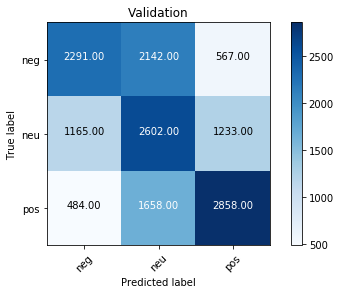

f1 score 0.5167333333333334
Accuracy 0.5167333333333334
amazon_movies fair_balanced_100
INFO:tensorflow:Writing example 0 of 15000


I0518 22:59:36.519826 139881778222976 run_classifier.py:774] Writing example 0 of 15000


INFO:tensorflow:*** Example ***


I0518 22:59:36.523173 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:59:36.528881 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] f ##oy ##les war is one of those rare television series that hits the nail on the head in de ##pic ##iting a past historical period . michael kitchen is a great actor and he is the perfect choice to play _ t ##k _ up _ dc ##s f ##oy ##le . the supporting cast is excellent also and the inter ##play between the characters is truly special . [SEP]


I0518 22:59:36.532690 139881778222976 run_classifier.py:464] tokens: [CLS] f ##oy ##les war is one of those rare television series that hits the nail on the head in de ##pic ##iting a past historical period . michael kitchen is a great actor and he is the perfect choice to play _ t ##k _ up _ dc ##s f ##oy ##le . the supporting cast is excellent also and the inter ##play between the characters is truly special . [SEP]


INFO:tensorflow:input_ids: 101 1042 6977 4244 2162 2003 2028 1997 2216 4678 2547 2186 2008 4978 1996 13774 2006 1996 2132 1999 2139 24330 15402 1037 2627 3439 2558 1012 2745 3829 2003 1037 2307 3364 1998 2002 2003 1996 3819 3601 2000 2377 1035 1056 2243 1035 2039 1035 5887 2015 1042 6977 2571 1012 1996 4637 3459 2003 6581 2036 1998 1996 6970 13068 2090 1996 3494 2003 5621 2569 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.535527 139881778222976 run_classifier.py:465] input_ids: 101 1042 6977 4244 2162 2003 2028 1997 2216 4678 2547 2186 2008 4978 1996 13774 2006 1996 2132 1999 2139 24330 15402 1037 2627 3439 2558 1012 2745 3829 2003 1037 2307 3364 1998 2002 2003 1996 3819 3601 2000 2377 1035 1056 2243 1035 2039 1035 5887 2015 1042 6977 2571 1012 1996 4637 3459 2003 6581 2036 1998 1996 6970 13068 2090 1996 3494 2003 5621 2569 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.538549 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.541435 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:59:36.543841 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:59:36.613513 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:59:36.614784 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] movie - _ number _ . _ number _ < br / > < br / > as i said in my review of the first film , i stand by the belief that the bourne franchise has ultimately changed the face of spy - thriller movies forever . sure , the occasional flash ##y james bond flick was fun to watch , but there ' s only so much style you can take after a while till it becomes a bit redundant . thankfully , these bourne films were so successful that they were able to re - imagine agent _ number _ in a different light , a dark , grit ##tier one that you can clearly see in their current films since daniel [SEP]


I0518 22:59:36.616565 139881778222976 run_classifier.py:464] tokens: [CLS] movie - _ number _ . _ number _ < br / > < br / > as i said in my review of the first film , i stand by the belief that the bourne franchise has ultimately changed the face of spy - thriller movies forever . sure , the occasional flash ##y james bond flick was fun to watch , but there ' s only so much style you can take after a while till it becomes a bit redundant . thankfully , these bourne films were so successful that they were able to re - imagine agent _ number _ in a different light , a dark , grit ##tier one that you can clearly see in their current films since daniel [SEP]


INFO:tensorflow:input_ids: 101 3185 1011 1035 2193 1035 1012 1035 2193 1035 1026 7987 1013 1028 1026 7987 1013 1028 2004 1045 2056 1999 2026 3319 1997 1996 2034 2143 1010 1045 3233 2011 1996 6772 2008 1996 15803 6329 2038 4821 2904 1996 2227 1997 8645 1011 10874 5691 5091 1012 2469 1010 1996 8138 5956 2100 2508 5416 17312 2001 4569 2000 3422 1010 2021 2045 1005 1055 2069 2061 2172 2806 2017 2064 2202 2044 1037 2096 6229 2009 4150 1037 2978 21707 1012 16047 1010 2122 15803 3152 2020 2061 3144 2008 2027 2020 2583 2000 2128 1011 5674 4005 1035 2193 1035 1999 1037 2367 2422 1010 1037 2601 1010 24842 17579 2028 2008 2017 2064 4415 2156 1999 2037 2783 3152 2144 3817 102


I0518 22:59:36.618300 139881778222976 run_classifier.py:465] input_ids: 101 3185 1011 1035 2193 1035 1012 1035 2193 1035 1026 7987 1013 1028 1026 7987 1013 1028 2004 1045 2056 1999 2026 3319 1997 1996 2034 2143 1010 1045 3233 2011 1996 6772 2008 1996 15803 6329 2038 4821 2904 1996 2227 1997 8645 1011 10874 5691 5091 1012 2469 1010 1996 8138 5956 2100 2508 5416 17312 2001 4569 2000 3422 1010 2021 2045 1005 1055 2069 2061 2172 2806 2017 2064 2202 2044 1037 2096 6229 2009 4150 1037 2978 21707 1012 16047 1010 2122 15803 3152 2020 2061 3144 2008 2027 2020 2583 2000 2128 1011 5674 4005 1035 2193 1035 1999 1037 2367 2422 1010 1037 2601 1010 24842 17579 2028 2008 2017 2064 4415 2156 1999 2037 2783 3152 2144 3817 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:59:36.620606 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.622883 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:59:36.625843 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:59:36.642888 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:59:36.644877 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] cr ##one ##nberg is the most surprising and shocking film director i know but he always deals with situations that are out of the ordinary and he pushes them to their extreme end or even beyond . in this film he explores the relation between two real twins who have perfectly identical routes in life to the point of becoming sc ##hi ##zo ##ph ##ren ##ic and wanting to get rid of the second half of their individual personality , which is the personality of the other . they become obsessed with separating the siam ##ese twins they are in a way and yet are not . this der ##ange ##ment develops all by itself and they discover that they cannot survive separately and as soon [SEP]


I0518 22:59:36.646767 139881778222976 run_classifier.py:464] tokens: [CLS] cr ##one ##nberg is the most surprising and shocking film director i know but he always deals with situations that are out of the ordinary and he pushes them to their extreme end or even beyond . in this film he explores the relation between two real twins who have perfectly identical routes in life to the point of becoming sc ##hi ##zo ##ph ##ren ##ic and wanting to get rid of the second half of their individual personality , which is the personality of the other . they become obsessed with separating the siam ##ese twins they are in a way and yet are not . this der ##ange ##ment develops all by itself and they discover that they cannot survive separately and as soon [SEP]


INFO:tensorflow:input_ids: 101 13675 5643 11144 2003 1996 2087 11341 1998 16880 2143 2472 1045 2113 2021 2002 2467 9144 2007 8146 2008 2024 2041 1997 1996 6623 1998 2002 13956 2068 2000 2037 6034 2203 2030 2130 3458 1012 1999 2023 2143 2002 15102 1996 7189 2090 2048 2613 8178 2040 2031 6669 7235 5847 1999 2166 2000 1996 2391 1997 3352 8040 4048 6844 8458 7389 2594 1998 5782 2000 2131 9436 1997 1996 2117 2431 1997 2037 3265 6180 1010 2029 2003 1996 6180 1997 1996 2060 1012 2027 2468 15896 2007 14443 1996 25583 6810 8178 2027 2024 1999 1037 2126 1998 2664 2024 2025 1012 2023 4315 22043 3672 11791 2035 2011 2993 1998 2027 7523 2008 2027 3685 5788 10329 1998 2004 2574 102


I0518 22:59:36.648618 139881778222976 run_classifier.py:465] input_ids: 101 13675 5643 11144 2003 1996 2087 11341 1998 16880 2143 2472 1045 2113 2021 2002 2467 9144 2007 8146 2008 2024 2041 1997 1996 6623 1998 2002 13956 2068 2000 2037 6034 2203 2030 2130 3458 1012 1999 2023 2143 2002 15102 1996 7189 2090 2048 2613 8178 2040 2031 6669 7235 5847 1999 2166 2000 1996 2391 1997 3352 8040 4048 6844 8458 7389 2594 1998 5782 2000 2131 9436 1997 1996 2117 2431 1997 2037 3265 6180 1010 2029 2003 1996 6180 1997 1996 2060 1012 2027 2468 15896 2007 14443 1996 25583 6810 8178 2027 2024 1999 1037 2126 1998 2664 2024 2025 1012 2023 4315 22043 3672 11791 2035 2011 2993 1998 2027 7523 2008 2027 3685 5788 10329 1998 2004 2574 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:59:36.652774 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.655585 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:59:36.657564 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:59:36.661847 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:59:36.664632 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] i love this documentary ! i love god and this sets me ab ##laze an ##ew . what evan roberts saw and did is what we need today . the video ( _ t ##k _ up _ dvd ) is well done , and brings you close to the moment . much of the dial ##og is in the words of evan himself or his contemporaries and the current narrator ##s do a good job of bringing you onto the scene . i can watch it over and over . [SEP]


I0518 22:59:36.667524 139881778222976 run_classifier.py:464] tokens: [CLS] i love this documentary ! i love god and this sets me ab ##laze an ##ew . what evan roberts saw and did is what we need today . the video ( _ t ##k _ up _ dvd ) is well done , and brings you close to the moment . much of the dial ##og is in the words of evan himself or his contemporaries and the current narrator ##s do a good job of bringing you onto the scene . i can watch it over and over . [SEP]


INFO:tensorflow:input_ids: 101 1045 2293 2023 4516 999 1045 2293 2643 1998 2023 4520 2033 11113 24472 2019 7974 1012 2054 9340 7031 2387 1998 2106 2003 2054 2057 2342 2651 1012 1996 2678 1006 1035 1056 2243 1035 2039 1035 4966 1007 2003 2092 2589 1010 1998 7545 2017 2485 2000 1996 2617 1012 2172 1997 1996 13764 8649 2003 1999 1996 2616 1997 9340 2370 2030 2010 16682 1998 1996 2783 11185 2015 2079 1037 2204 3105 1997 5026 2017 3031 1996 3496 1012 1045 2064 3422 2009 2058 1998 2058 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.670511 139881778222976 run_classifier.py:465] input_ids: 101 1045 2293 2023 4516 999 1045 2293 2643 1998 2023 4520 2033 11113 24472 2019 7974 1012 2054 9340 7031 2387 1998 2106 2003 2054 2057 2342 2651 1012 1996 2678 1006 1035 1056 2243 1035 2039 1035 4966 1007 2003 2092 2589 1010 1998 7545 2017 2485 2000 1996 2617 1012 2172 1997 1996 13764 8649 2003 1999 1996 2616 1997 9340 2370 2030 2010 16682 1998 1996 2783 11185 2015 2079 1037 2204 3105 1997 5026 2017 3031 1996 3496 1012 1045 2064 3422 2009 2058 1998 2058 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.673427 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.676232 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:59:36.679104 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


I0518 22:59:36.685326 139881778222976 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0518 22:59:36.687875 139881778222976 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] this movie is dirty good . it is wrong for all the right reasons . it will turn you on , confuse you , teach you and am ##use you . it has a real story line , but its more of a story line from an adult anime or manga , but it apply ##s this story to real live people . the main story is about a man ' s love for his life long maid - roi ##d maria . she is not programmed for the exact purposes he wants and her batteries won ' t last forever ( or will they ) . there is a side story going on at the same time , that you ' ll just have to [SEP]


I0518 22:59:36.691332 139881778222976 run_classifier.py:464] tokens: [CLS] this movie is dirty good . it is wrong for all the right reasons . it will turn you on , confuse you , teach you and am ##use you . it has a real story line , but its more of a story line from an adult anime or manga , but it apply ##s this story to real live people . the main story is about a man ' s love for his life long maid - roi ##d maria . she is not programmed for the exact purposes he wants and her batteries won ' t last forever ( or will they ) . there is a side story going on at the same time , that you ' ll just have to [SEP]


INFO:tensorflow:input_ids: 101 2023 3185 2003 6530 2204 1012 2009 2003 3308 2005 2035 1996 2157 4436 1012 2009 2097 2735 2017 2006 1010 28679 2017 1010 6570 2017 1998 2572 8557 2017 1012 2009 2038 1037 2613 2466 2240 1010 2021 2049 2062 1997 1037 2466 2240 2013 2019 4639 8750 2030 8952 1010 2021 2009 6611 2015 2023 2466 2000 2613 2444 2111 1012 1996 2364 2466 2003 2055 1037 2158 1005 1055 2293 2005 2010 2166 2146 10850 1011 25223 2094 3814 1012 2016 2003 2025 16984 2005 1996 6635 5682 2002 4122 1998 2014 10274 2180 1005 1056 2197 5091 1006 2030 2097 2027 1007 1012 2045 2003 1037 2217 2466 2183 2006 2012 1996 2168 2051 1010 2008 2017 1005 2222 2074 2031 2000 102


I0518 22:59:36.694658 139881778222976 run_classifier.py:465] input_ids: 101 2023 3185 2003 6530 2204 1012 2009 2003 3308 2005 2035 1996 2157 4436 1012 2009 2097 2735 2017 2006 1010 28679 2017 1010 6570 2017 1998 2572 8557 2017 1012 2009 2038 1037 2613 2466 2240 1010 2021 2049 2062 1997 1037 2466 2240 2013 2019 4639 8750 2030 8952 1010 2021 2009 6611 2015 2023 2466 2000 2613 2444 2111 1012 1996 2364 2466 2003 2055 1037 2158 1005 1055 2293 2005 2010 2166 2146 10850 1011 25223 2094 3814 1012 2016 2003 2025 16984 2005 1996 6635 5682 2002 4122 1998 2014 10274 2180 1005 1056 2197 5091 1006 2030 2097 2027 1007 1012 2045 2003 1037 2217 2466 2183 2006 2012 1996 2168 2051 1010 2008 2017 1005 2222 2074 2031 2000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0518 22:59:36.699330 139881778222976 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0518 22:59:36.701325 139881778222976 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


I0518 22:59:36.704375 139881778222976 run_classifier.py:468] label: Neutral (id = 1)


KeyboardInterrupt: ignored

In [6]:
for task in tasks:
  for subtask in sub_tasks:

    df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/train.csv")
    df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task+"/"+subtask+"/test.csv")

    df_trn = df_trn[["text", "label"]]
    df_tst = df_tst[["text", "label"]]
    
    df_trn['text'] = df_trn['text'].astype(str)
    df_tst['text'] = df_tst['text'].astype(str)

    df_trn = df_trn.sample(frac=1)
    df_tst = df_tst.sample(frac=1)

    train_InputExamples = df_trn.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                       text_a = x[DATA_COLUMN], 
                                                                       text_b = None, 
                                                                       label = x[LABEL_COLUMN]), axis = 1)

    test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                       text_a = x[DATA_COLUMN], 
                                                                       text_b = None, 
                                                                       label = x[LABEL_COLUMN]), axis = 1)


    # Convert our train and test features to InputFeatures that BERT understands.
    train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
    test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

    # Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir="model",
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    # Create an input function for training. drop_remainder = True for using TPUs.
    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=True,
        drop_remainder=False)

    # Compute # train and warmup steps from batch size
    num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
    print(num_train_steps)
    print(num_warmup_steps)


    model_fn = model_fn_builder(
        num_labels=len(label_list),
        learning_rate=LEARNING_RATE,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
        model_fn=model_fn,
        config=run_config,
        params={"batch_size": BATCH_SIZE})

    print(f'Beginning Training!')
    current_time = datetime.now()
    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
    print("Training took time ", datetime.now() - current_time)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)

    predictions = get_prediction(df_tst[DATA_COLUMN])
    pred_labels = [pred[2] for pred in predictions]


    cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
    plot_confusion_matrix(cm_test,
                          ['neg', 'neu', 'pos'],
                          normalize=False,
                          title='Validation')
    print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))
    print("Accuracy", accuracy_score(df_tst["label"], pred_labels))

    new_col_name = ".".join(['bert', subtask.split('_')[-1], task])

    for task_tst in tasks:
      subtask_tst = 'fair_balanced_100'
      df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task_tst+"/"+subtask_tst+"/test.csv")
      df_tst['text'] = df_tst['text'].astype(str)
      print(task_tst, subtask_tst)

      predictions = get_prediction(df_tst[DATA_COLUMN])
      pred_labels = [pred[2] for pred in predictions]

      cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
      plot_confusion_matrix(cm_test,
                            ['neg', 'neu', 'pos'],
                            normalize=False,
                            title='Validation')
      print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))
      print("Accuracy", accuracy_score(df_tst["label"], pred_labels))

      df_tst[new_col_name] = pred_labels

      df_tst.to_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/"+task_tst+"/"+subtask_tst+"/test.csv", index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')



In [0]:
df_tst['label'].value_counts()

Neutral     5000
Negative    5000
Positive    5000
Name: label, dtype: int64

In [0]:
df_tst['text']

0        Worked great. I used the boil method. Follow d...
1        I think I stuttered and stammered for close to...
2        I've had my Fitbit for over 1 1/2 years, havin...
3        Really nice razor. I like the twist to open fe...
4        These caps are great, they open easy and stay ...
5        Be careful not to put much of this on the pads...
6        This is a beautiful aroma to me. I usually mix...
7        I am very happy with this product so far. I am...
8        I did a lot of research for my 84 year old mot...
9        I would not be without MSM.  I have been using...
10       I have used this sleep mask for about 6 years,...
11       Well first off, I have to say shipping on this...
12       I do not find the 'foot taste' objectionable. ...
13       I don't think you can find any better value th...
14       Knowing about the ingredients about this produ...
15       If you are faithful to put this on every night...
16       These hold up well to typical household use an.

'bert.100.amazon_movies'

Now the below is just an adhoc example of what we can do to evaluate this

Confusion matrix, without normalization
[[3567 1251  182]
 [1883 2187  930]
 [ 940 1297 2763]]


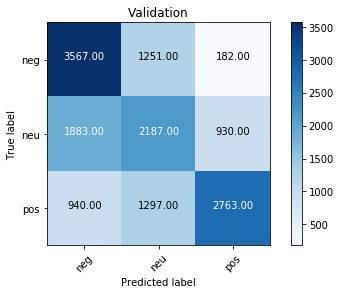

f1 score 0.5678
Accuracy 0.5678


Now we can predict completely made up adhoc examples:

In [0]:
from collections import Counter
Counter(pred_labels)

Counter({'Negative': 6393, 'Neutal': 4749, 'Positive': 3858})

In [0]:
df_tst

,text,label
9516,"If you like Jim Carrey, and want to see him in...",Neutral
11298,Okay let's start at the beginning.<p>1)The sto...,Negative
9350,This is a classic musical film and I have noth...,Neutral
1902,I saw this video at a party and enjoyed it so ...,Positive
10826,Let me see if I have this straight. Madeline'...,Negative
3379,The film Boodock Saints can be considered a cu...,Positive
3654,"Good movie, done in a very stylish, classy way...",Positive
10443,What a disappointment. My grand kids love the...,Negative
10139,This was truly a waste of film and time. You w...,Negative
322,I have the entire set of Carmen Electra's Stri...,Positive


Voila! We have a sentiment classifier!

In [0]:
predictions[0][2]